## Air Quality - Madrid (2001 - 2018)

Time series and prediction for the years 2017 - 2019

In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('seaborn')
%matplotlib inline

### Load and merge training data (2001 to 2017). 

Not all dataframes have the same structure, I use pd.concat with axis=0 to end up with a dataframe containing all the columns from all the csv's files. NaN added for missing values.

In [2]:
df = pd.read_csv('data\csvs_per_year\madrid_2001.csv')

for year in range(2002, 2017):
    df_temp = pd.read_csv(f'data\csvs_per_year\madrid_{year}.csv')
    df = pd.concat([df, df_temp], axis = 0)

In [3]:
#set date column as index
df = pd.DataFrame(df, columns=list(df.columns)).set_index('date')

### Load and merge test data (2018)

In [4]:
df_test = pd.read_csv('data\csvs_per_year\madrid_2017.csv')
df_temp = pd.read_csv(f'data\csvs_per_year\madrid_2018.csv')
df_test = pd.concat([df_test, df_temp], axis = 0)
df_test = pd.DataFrame(df_test, columns=list(df_test.columns)).set_index('date')

### Sort by dates

In [5]:
# convert date column from object to datetime type
df.index = pd.to_datetime(df.index)
df_test.index = pd.to_datetime(df_test.index)

# sort by date
df.sort_index(inplace=True)
df_test.sort_index(inplace=True)

### NaN values

In [6]:
# percentage of NaN values per column
df_nan = df.isna().mean().round(4) * 100
df_nan

BEN        72.39
CO         28.16
EBE        73.51
MXY        91.06
NMHC       70.21
NO_2        0.56
NOx        36.11
OXY        91.05
O_3        19.80
PM10       22.92
PXY        91.06
SO_2       24.61
TCH        70.17
TOL        72.46
station     0.00
PM25       78.88
NO         64.45
dtype: float64

From here it can be seen that MXY, OXY, PXY and CH4 are more than 90% NaN values. Also, BEN, EBE, NMHC, TCH, TOL and PM25 are more than 70% NaN values. Not much information will be drown from these pollutants. 

In this analysis I will look at NO2, O3, PM10 and SO2. In https://www.londonair.org.uk/LondonAir/nowcast.aspx only NO2, O3, PM10 and PM25 are reported.


In [7]:
df=df.drop(columns=['NO', 'BEN', 'EBE', 'MXY', 'NMHC', 'OXY', 'PXY', 'TCH', 'TOL', 'PM25','NOx', 'station'])
df.head()

,CO,NO_2,O_3,PM10,SO_2
date,,,,,
2001-01-01 01:00:00,1.45,50.389999,4.180000,21.219999,10.86
2001-01-01 01:00:00,1.25,55.290001,7.830000,30.559999,22.10
2001-01-01 01:00:00,0.87,53.400002,8.350000,36.669998,11.42
2001-01-01 01:00:00,0.79,47.320000,3.400000,14.440000,9.69
2001-01-01 01:00:00,0.67,43.820000,32.490002,11.890000,9.35


In [8]:
pollutants_nan_percentage = df.isna().mean().round(4)*100

<AxesSubplot:title={'center':'Percentage of NaN values'}, xlabel='Pollutant', ylabel='NaN percentage (%)'>

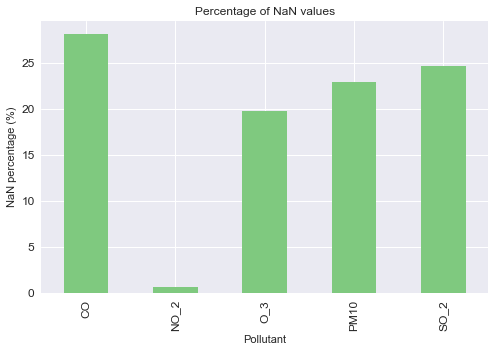

In [9]:
plt.figure(figsize=(8, 5))
pollutants_nan_percentage.plot(
    xlabel='Pollutant', 
    ylabel='NaN percentage (%)', 
    kind='bar', 
    title='Percentage of NaN values',
    fontsize = 12,
    colormap = 'Accent'
)


### Summary

In [10]:
df.describe().round(2)

,CO,NO_2,O_3,PM10,SO_2
count,2535413.00,3509159.00,2830285.00,2720203.00,2660571.00
mean,0.56,51.23,39.39,29.49,10.84
std,0.54,34.67,30.16,26.25,9.21
min,0.00,0.00,0.00,0.00,0.00
25%,0.27,24.80,12.54,11.93,6.00
50%,0.40,45.00,34.07,22.00,8.28
75%,0.66,70.33,59.00,38.47,12.50
max,18.04,628.60,236.00,695.00,199.10


There is a huge difference between Median and Maximum values. There must be outliers present. 

### Further data exploration

How widely is the data distributed?

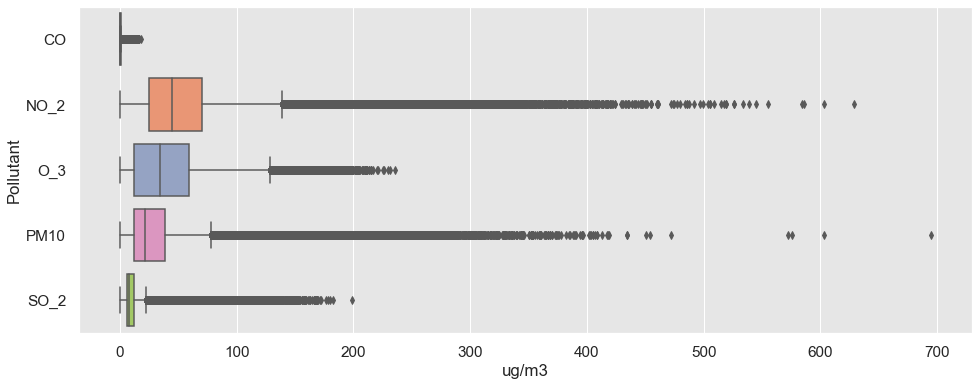

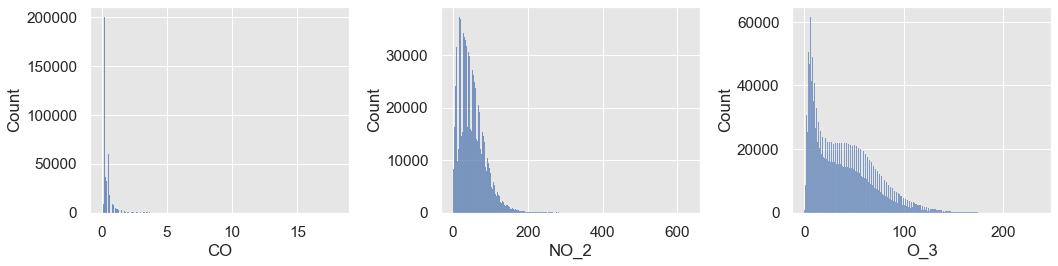

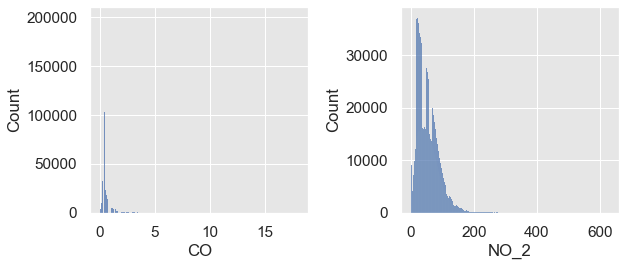

In [11]:
plt.figure(figsize=(16, 6))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("notebook", font_scale=1.4)
plt.ylabel('Pollutant')
plt.xlabel('ug/m3')
ax = sns.boxplot(data=df, orient="h", palette="Set2")

fig, axs = plt.subplots(ncols=3,figsize=(15, 4))
sns.histplot(df, x="CO", ax=axs[0])
sns.histplot(df, x="NO_2",ax=axs[1])
sns.histplot(df, x="O_3",ax=axs[2])
plt.tight_layout()

fig, axs = plt.subplots(ncols=2,figsize=(9, 4))
sns.histplot(df, x="CO", ax=axs[0])
sns.histplot(df, x="NO_2",ax=axs[1])
plt.tight_layout()

From above, we find that there are too many high unexpected values. This is conditional to the inherent events within the city, where dense air pollution might have occured due to heavy traffic from huge number of vehicles.

Looking at maximum values per day

In [12]:
df_max_day = df.copy()
df_max_day.index = df_max_day.index.to_period('D')
df_max_day = df_max_day.groupby(by=df_max_day.index).max()
df_max_day.tail()

,CO,NO_2,O_3,PM10,SO_2
date,,,,,
2016-12-28,2.1,208.0,47.0,91.0,32.0
2016-12-29,3.8,262.0,51.0,97.0,40.0
2016-12-30,3.6,261.0,46.0,96.0,46.0
2016-12-31,3.0,215.0,41.0,66.0,53.0
2017-01-01,1.0,132.0,8.0,57.0,18.0


In [13]:
df_max_day.head()

,CO,NO_2,O_3,PM10,SO_2
date,,,,,
2001-01-01,6.36,114.300003,83.160004,159.399994,68.739998
2001-01-02,3.55,108.500000,101.199997,108.300003,79.910004
2001-01-03,4.20,111.300003,57.980000,113.699997,73.500000
2001-01-04,4.41,109.900002,67.500000,171.699997,76.199997
2001-01-05,5.74,102.300003,49.540001,132.699997,61.180000


<AxesSubplot:xlabel='SO_2', ylabel='Count'>

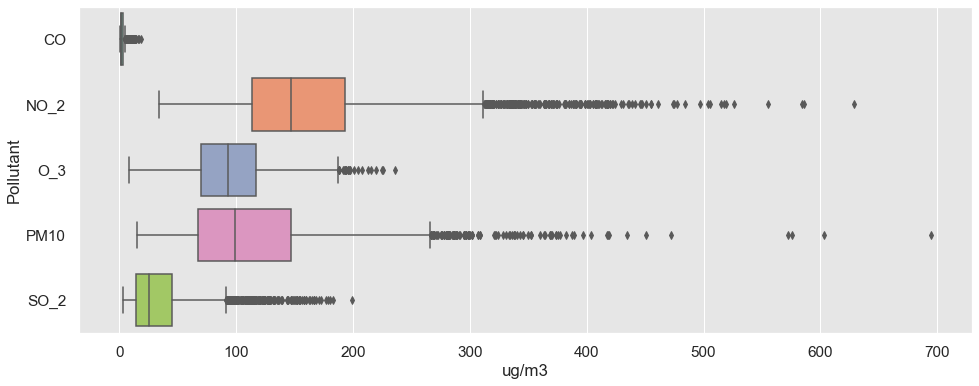

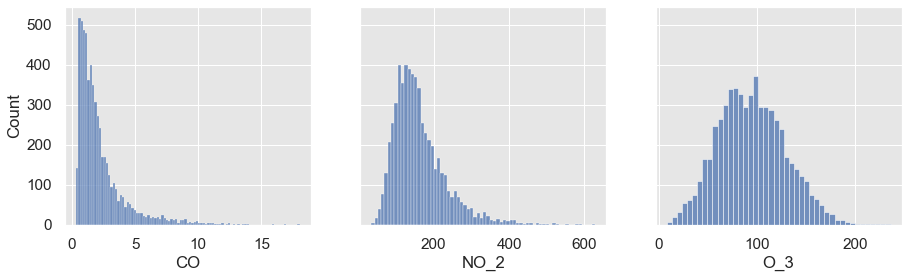

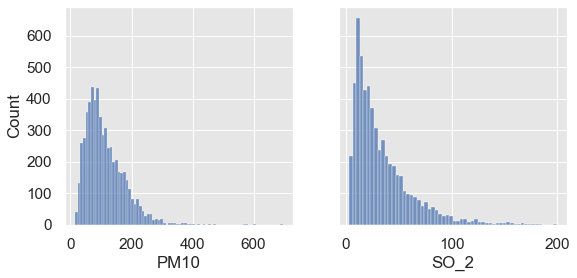

In [14]:

plt.figure(figsize=(16, 6))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("notebook", font_scale=1.4)
plt.ylabel('Pollutant')
plt.xlabel('ug/m3')
ax = sns.boxplot(data=df_max_day, orient="h", palette="Set2")

fig, axs = plt.subplots(ncols=3,figsize=(15, 4), sharey=True)
sns.histplot(df_max_day, x="CO", ax=axs[0])
sns.histplot(df_max_day, x="NO_2",ax=axs[1])
sns.histplot(df_max_day, x="O_3",ax=axs[2])

fig, axs = plt.subplots(ncols=2,figsize=(9, 4), sharey=True)
sns.histplot(df_max_day, x="PM10", ax=axs[0])
sns.histplot(df_max_day, x="SO_2",ax=axs[1])

After aggregating, it is shown that the plots are bit more normalized in comparison to the previous ones, but still we find some outliers in this case.

In [15]:
# Monthly average - maximum value per day
df_monthAvg = df_max_day.copy()
# reset index to datetime
df_monthAvg.index = df_monthAvg.index.to_timestamp()
df_monthAvg.index=df_monthAvg.index.to_period('M')
df_monthAvg = df_monthAvg.groupby(by=df_monthAvg.index).mean()


In [16]:
df_monthAvg.tail()

,CO,NO_2,O_3,PM10,SO_2
date,,,,,
2016-09,1.223333,163.300000,122.833333,80.166667,24.366667
2016-10,1.690323,166.354839,93.967742,78.612903,23.741935
2016-11,1.506667,140.133333,67.733333,57.733333,28.033333
2016-12,2.070968,179.000000,58.774194,69.000000,28.870968
2017-01,1.000000,132.000000,8.000000,57.000000,18.000000


In [17]:
# delete last row to get rid of 2018 data
df_monthAvg = df_monthAvg[:-1]
df_monthAvg.tail()

,CO,NO_2,O_3,PM10,SO_2
date,,,,,
2016-08,0.983871,140.032258,143.967742,101.419355,23.870968
2016-09,1.223333,163.300000,122.833333,80.166667,24.366667
2016-10,1.690323,166.354839,93.967742,78.612903,23.741935
2016-11,1.506667,140.133333,67.733333,57.733333,28.033333
2016-12,2.070968,179.000000,58.774194,69.000000,28.870968


### Series of the pollutants from Jan 2001 to Dec 2017
Monthly averaged from max per day

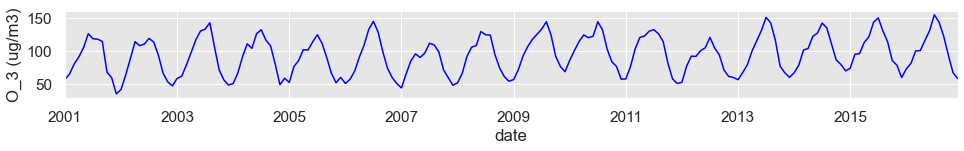

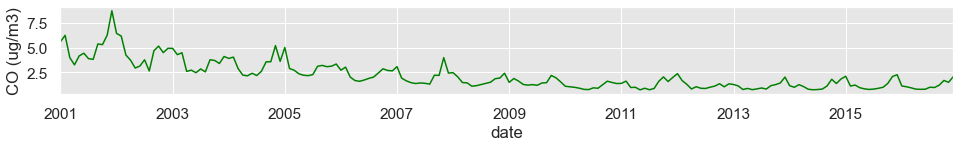

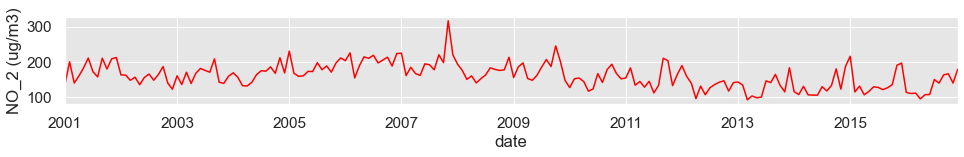

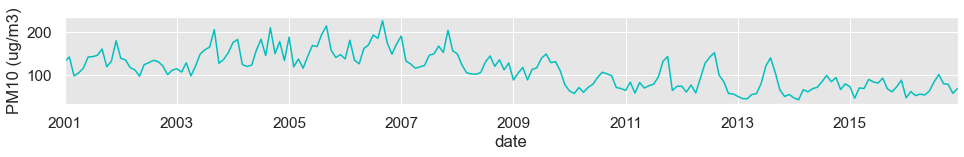

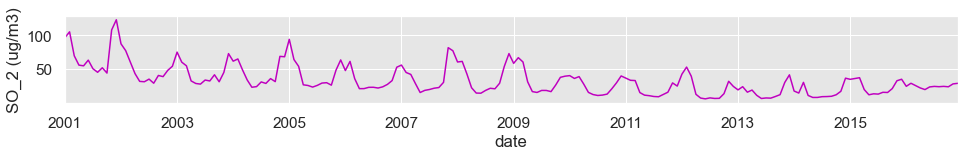

In [18]:
pollutants = ['O_3', 'CO', 'NO_2', 'PM10', 'SO_2']
colors = ['b', 'g', 'r', 'c', 'm']

for pollutant, color in zip(pollutants, colors):
    plt.figure(figsize=(16, 1.6))
    ax = df_monthAvg[pollutant].plot(color=color, y=pollutant)
    ax.set_ylabel(pollutant+' (ug/m3)')

### The combined effect of the pollutants
#### 1. Yearly moving average of the sum of the 5 pollutants

In [19]:
df_yearAvg = df.copy()
df_yearAvg.index = df_yearAvg.index.to_period('Y')
df_yearAvg = df_yearAvg.groupby(by=df_yearAvg.index).mean()

# drop 2018-01-01 00:00:000 readings, and sum all pollutants
df_yearAvg = df_yearAvg[:-1].sum(axis=1).to_frame()
df_yearAvg.rename(columns={df_yearAvg.columns[0]:'Avg_total_pollution'}, inplace=True)
df_yearAvg.index = df_yearAvg.index.to_timestamp()

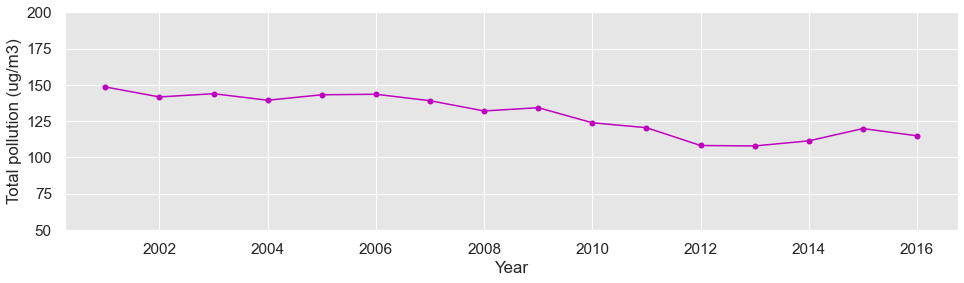

In [20]:
plt.figure(figsize=(16, 4))
plt.plot(df_yearAvg.index, df_yearAvg['Avg_total_pollution'],linestyle='-', marker='o', color='m')
plt.ylim(50, 200)

plt.ylabel('Total pollution (ug/m3)')
plt.xlabel('Year')
plt.show()

### The combined effect of the pollutants
#### 2. Monthly average over the years

In [21]:
df_monthAvg = df.copy()
df_monthAvg = df_monthAvg.groupby(by=df.index.month).mean()
df_monthAvg = df_monthAvg.sum(axis=1).to_frame()
df_monthAvg.rename(columns={df_monthAvg.columns[0]:'Avg_total_pollution'}, inplace=True)

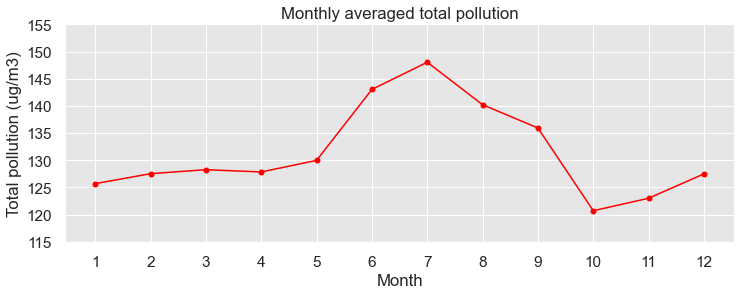

In [22]:
ax = df_monthAvg.plot(
        figsize=(12,4),
        linestyle='-', 
        marker='o', 
        title='Monthly averaged total pollution',
        legend=False,
        yticks=range(115,160,5),
        xticks=range(1,13),
        color='r'
    )

ax.set_ylabel('Total pollution (ug/m3)')
ax.set_xlabel('Month')
plt.show()

There is a spike of pollution between May and October, getting to a maximum every July.

### The combined effect of the pollutants
#### 3. Hourly average over the years

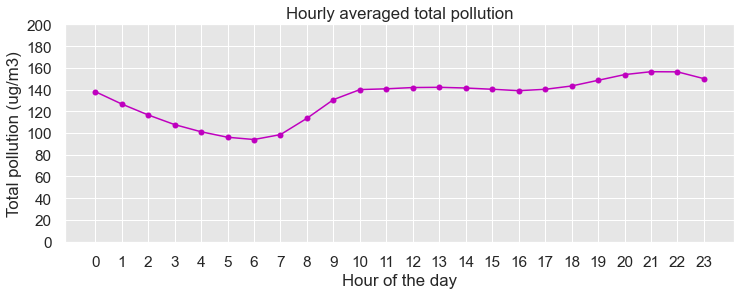

In [23]:
df_hourAvg = df.copy()
df_hourAvg = df_hourAvg.groupby(by=df.index.hour).mean()
df_hourAvg = df_hourAvg.sum(axis=1).to_frame()
df_hourAvg.rename(columns={df_hourAvg.columns[0]:'Avg_total_pollution'}, inplace=True)

ax = df_hourAvg.plot(
        figsize=(12,4),
        linestyle='-', 
        marker='o', 
        title='Hourly averaged total pollution',
        legend=False,
        yticks=range(0,210,20),
        xticks=range(24),
        color='m'
    )

ax.set_ylabel('Total pollution (ug/m3)')
ax.set_xlabel('Hour of the day')
plt.show()

While humans sleep at night, the air quality improves, until they start their human activities from 6-7 am.

### Forecasting for 2017 - 2019
Forecasting will be performed for Ozone.

#### 1. Ozone
Decomposition of ozone time series.

In [24]:
df_roll = df.copy()
df_roll.index = df_roll.index.to_period('M')
df_roll = df_roll.groupby(by=df_roll.index).mean()
roll_mean = df_roll['O_3'].rolling(window=12).mean()
roll_std = df_roll['O_3'].rolling(window=12).std()
df_roll.index = df_roll.index.to_timestamp()

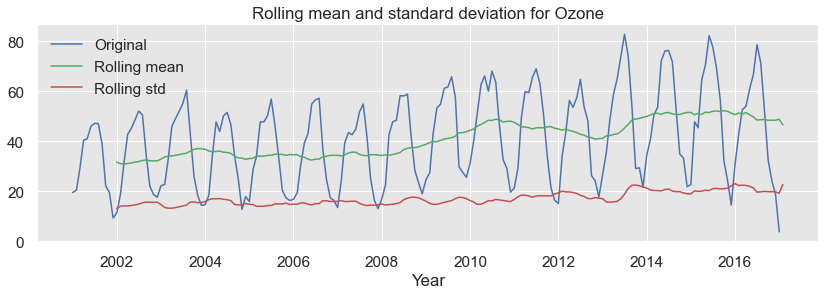

In [25]:
# rolling statistics for ozone
plt.figure(figsize=(14,4))
plt.plot(df_roll['O_3'], label='Original')
plt.plot(roll_mean, label='Rolling mean')
plt.plot(roll_std, label='Rolling std')
plt.title('Rolling mean and standard deviation for Ozone')
plt.legend(loc='best')
plt.xlabel('Year')
plt.show(block=False)

Augmented Dickey-Fuller test

In [26]:
print(" > Is the data stationary?")
dftest = adfuller(df_roll['O_3'], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary?
Test statistic = -1.537
P-value = 0.515
Critical values :
	1%: -3.467845319799907 - The data is not stationary with 99% confidence
	5%: -2.878011745497439 - The data is not stationary with 95% confidence
	10%: -2.575551186759871 - The data is not stationary with 90% confidence


p-value is very high.

Text(0.5, 0, 'Year')

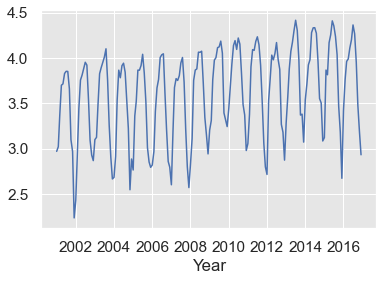

In [27]:
# trend
df_log=np.log(df_roll['O_3'])
df_log=df_log[:-1]
plt.plot(df_log)
plt.xlabel('Year')

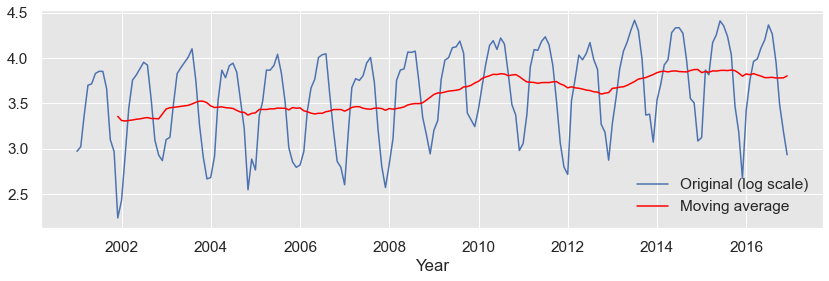

In [28]:
movingAvg = df_log.rolling(window=12).mean()
movingStd = df_log.rolling(window=12).std()

plt.figure(figsize=(14,4))
plt.plot(df_log, label='Original (log scale)')
plt.plot(movingAvg, label='Moving average', color='red')
plt.xlabel('Year')
plt.legend(loc='best')

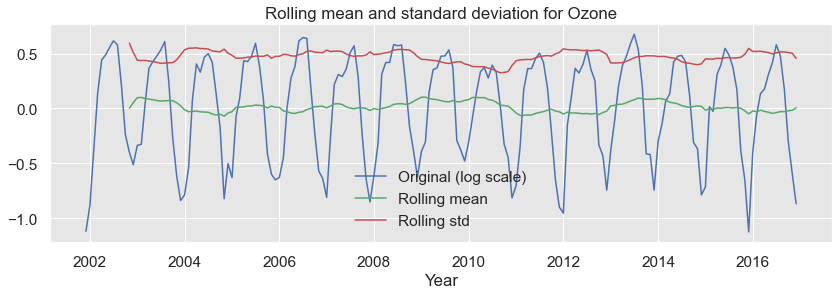

 > Is the data stationary?
Test statistic = -2.971
P-value = 0.038
Critical values :
	1%: -3.4698858990744115 - The data is not stationary with 99% confidence
	5%: -2.8789026251889647 - The data is  stationary with 95% confidence
	10%: -2.5760266680839004 - The data is  stationary with 90% confidence


In [29]:
df_minus_movingAvg = df_log - movingAvg
df_minus_movingAvg.dropna(inplace=True)

roll_mean = df_minus_movingAvg.rolling(window=12).mean()
roll_std = df_minus_movingAvg.rolling(window=12).std()

# rolling statistics for ozone
plt.figure(figsize=(14,4))
plt.plot(df_minus_movingAvg, label='Original (log scale)')
plt.plot(roll_mean, label='Rolling mean')
plt.plot(roll_std, label='Rolling std')
plt.title('Rolling mean and standard deviation for Ozone')
plt.legend(loc='best')
plt.xlabel('Year')
plt.show(block=False)

print(" > Is the data stationary?")
dftest = adfuller(df_minus_movingAvg, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

Calculate parameters for ARIMA model. First, for d:

In [30]:
# taking lag=1
df_logDiffShift = df_log - df_log.shift()

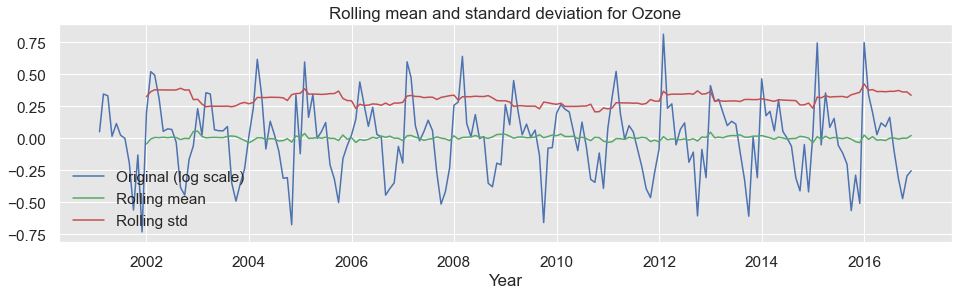

 > Is the data stationary?
Test statistic = -8.557
P-value = 0.000
Critical values :
	1%: -3.4674201432469816 - The data is  stationary with 99% confidence
	5%: -2.877826051844538 - The data is  stationary with 95% confidence
	10%: -2.575452082332012 - The data is  stationary with 90% confidence


In [31]:
df_logDiffShift.dropna(inplace=True)

roll_mean = df_logDiffShift.rolling(window=12).mean()
roll_std = df_logDiffShift.rolling(window=12).std()

# rolling statistics for ozone
plt.figure(figsize=(16,4))
plt.plot(df_logDiffShift, label='Original (log scale)')
plt.plot(roll_mean, label='Rolling mean')
plt.plot(roll_std, label='Rolling std')
plt.title('Rolling mean and standard deviation for Ozone')
plt.legend(loc='best')
plt.xlabel('Year')
plt.show(block=False)

print(" > Is the data stationary?")
dftest = adfuller(df_logDiffShift, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

The above shows that the time series is stationary after 1-order differencing. Now let's look at the components of the time series.

Text(0.5, 40.99999999999994, 'Year')

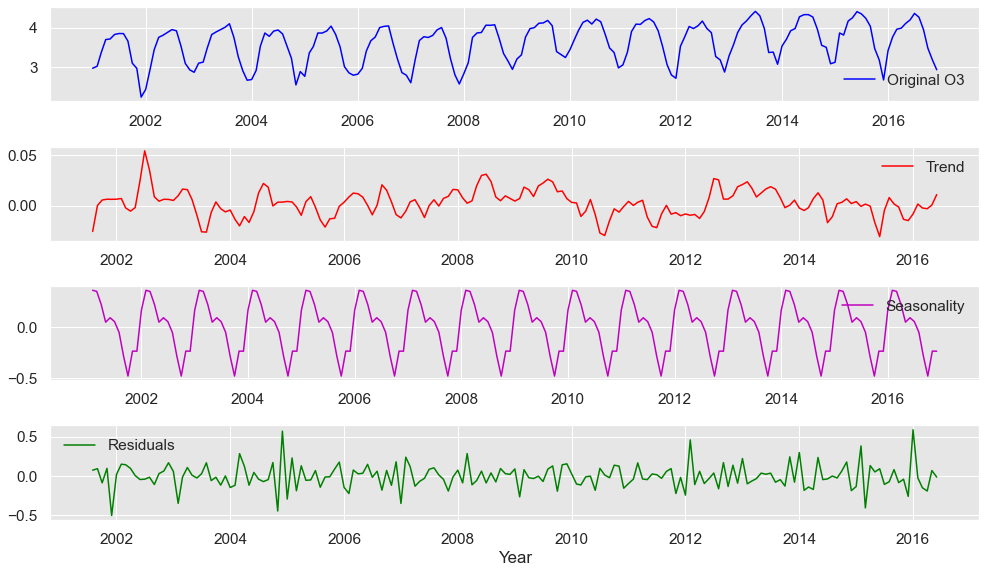

In [32]:
decomposition = seasonal_decompose(df_logDiffShift)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(14,8))
plt.subplot(411)
plt.plot(df_log, color='b', label='Original O3')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, color='r', label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, color='m',label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, color='g', label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.xlabel('Year')

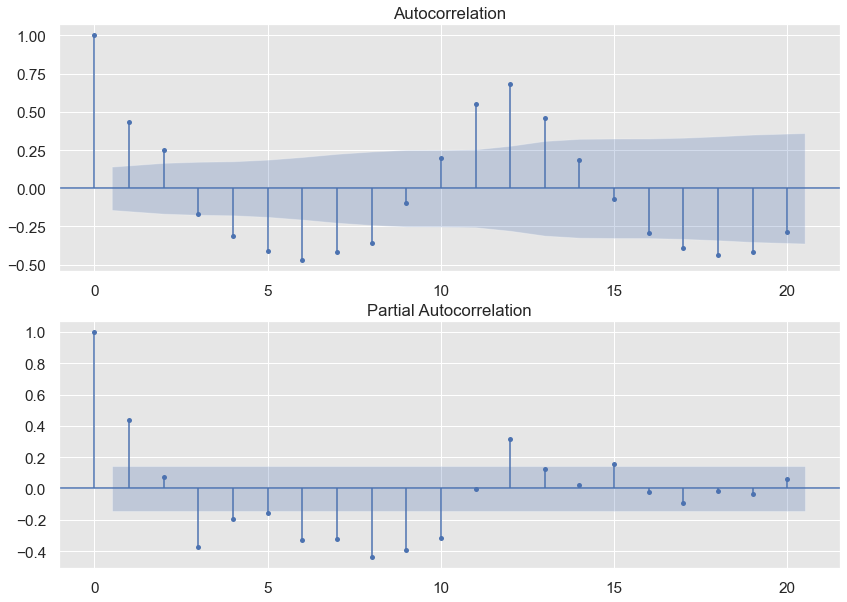

In [33]:
fig, ax = plt.subplots(2, figsize=(14,10))
ax[0] = plot_acf(df_logDiffShift, ax=ax[0], lags=20)
ax[1] = plot_pacf(df_logDiffShift, ax=ax[1], lags=20)

                               SARIMAX Results                                
Dep. Variable:                    O_3   No. Observations:                  192
Model:                          ARIMA   Log Likelihood                -136.788
Date:                Tue, 20 Oct 2020   AIC                            277.576
Time:                        16:44:58   BIC                            284.091
Sample:                    01-01-2001   HQIC                           280.215
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6021      0.039     91.258      0.000       3.525       3.679
sigma2         0.2434      0.035      6.919      0.000       0.174       0.312
Ljung-Box (L1) (Q):                 129.07   Jarque-

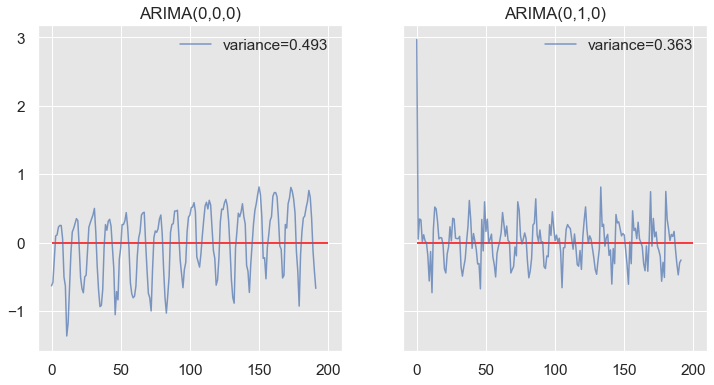

In [34]:
model = ARIMA(df_log, order=(0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(df_log, order=(0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=200, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=200, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();

                               SARIMAX Results                                
Dep. Variable:                    O_3   No. Observations:                  192
Model:                 ARIMA(1, 0, 2)   Log Likelihood                   9.063
Date:                Tue, 20 Oct 2020   AIC                             -8.127
Time:                        16:44:59   BIC                              8.161
Sample:                    01-01-2001   HQIC                            -1.530
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5859      0.098     36.471      0.000       3.393       3.779
ar.L1          0.6224      0.069      9.008      0.000       0.487       0.758
ma.L1          0.5236      0.080      6.579      0.0

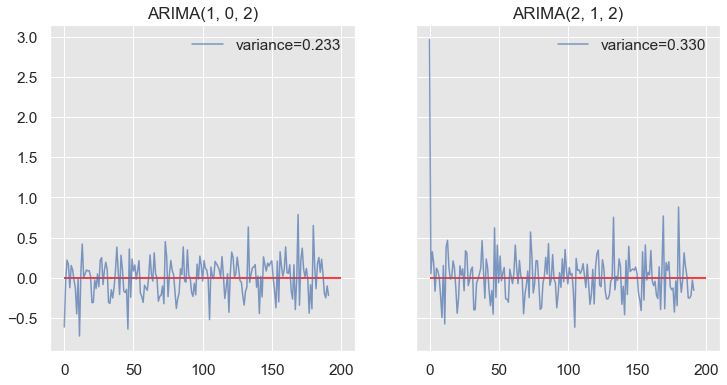

In [35]:
model = ARIMA(df_log, order=(1, 0, 2))
res_102 = model.fit()
print(res_102.summary())

model = ARIMA(df_log, order=(2, 1, 2))
res_212 = model.fit()
print(res_212.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_102.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_102.resid.values)));
ax[0].hlines(0, xmin=0, xmax=200, color='r');
ax[0].set_title("ARIMA(1, 0, 2)");
ax[0].legend();
ax[1].plot(res_212.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_212.resid.values)));
ax[1].hlines(0, xmin=0, xmax=200, color='r');
ax[1].set_title("ARIMA(2, 1, 2)");
ax[1].legend();

### Prediction 

<AxesSubplot:xlabel='date'>

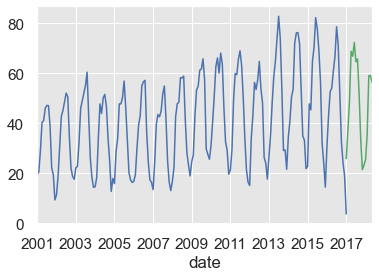

In [36]:
# load train dataset 
df_train_roll = df.copy()
df_train_roll.index = df_train_roll.index.to_period('M')
df_train_roll = df_train_roll.groupby(by=df_train_roll.index).mean()
df_train_roll.index = df_train_roll.index.to_timestamp()
df_train_roll['O_3'].plot()

# test dataset for Ozone 2017 onwards
df_test_roll = df_test.copy()
df_test_roll.index = df_test_roll.index.to_period('M')
df_test_roll = df_test_roll.groupby(by=df_test_roll.index).mean()
df_test_roll.index = df_test_roll.index.to_timestamp()
df_test_roll['O_3'].plot()

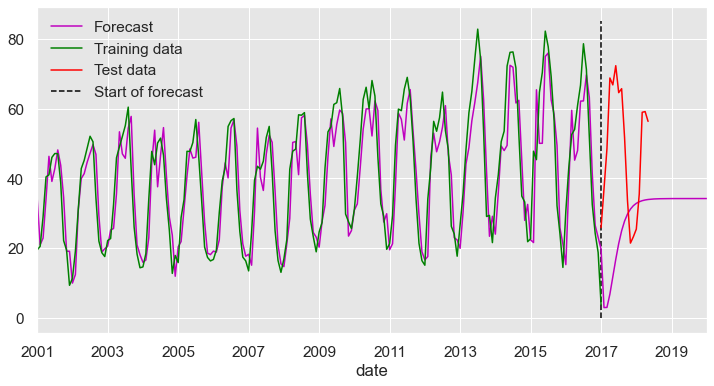

In [59]:
df_train_log = np.log(df_train_roll['O_3'])
model = ARIMA(df_train_log, order=(1,0,2))
res_102 = model.fit()
predict = np.exp(res_102.predict('2001-01', '2020-01', dynamic=False))

fig, ax = plt.subplots(figsize=(12, 6))
ax = predict.plot(label='Forecast', color='m')
ax = np.exp(df_train_log).plot(label='Training data', color='g')
ax = df_test_roll['O_3'].plot(label='Test data', color='r')
ax.vlines('2017-01', 0, 85, linestyle='--', color='k', label='Start of forecast')
plt.legend(loc='best')
plt.show()